In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd()))

from berp.generators import thresholded_recognition

In [98]:
X_word, X_phon, y = thresholded_recognition.sample_item("In the episode, she learns that her then estranged husband is releasing a new song",
                                                       recognition_threshold=torch.tensor(0.9))

in the episode she learns that her then estranged husband is releasing a new song
Ġthe ['the', 'the', 'and', 'of', 'to', 'a', 's']
Ġepisode ['episode', 'same', 'past', 'world', 'early', 'first', 'end', 'name', 'united', 'future']
Ġshe ['she', 's', 'of', 'where', 'that', 'is', 'was']
Ġlearns ['learns', 's', 'says', 'said', 'is', 'had', 'tells', 'has', 'talks', 'told']
Ġthat ['that', 'about', 'the', 'of', 'to', 'she', 'from', 'how', 'a', 'her']
Ġher ['her', 'she', 'her', 'a', 'there', 'he', 'it', 'they', 'his', 'one']
Ġthen ['then', 'mother', 'husband', 'parents', 'brother', 'sister', 'boyfriend', 'son', 'dad', 'family']
Ġestranged ['estranged', 'husband', 'boyfriend', 'girlfriend', 'fian', 'wife', 'father', 'boss', 'best', 'fiance']
Ġhusband ['husband', 'father', 'son', 'mother', 'boyfriend', 'brother', 'wife', 'lover', 'sister', 'daughter']
Ġis ['is', 'is', 'has', 'was', 'had', 's', 'and', 'will', 'died']
Ġreleasing ['releasing', 'the', 'now', 'in', 'actually', 'still', 'also', 'not', 

In [99]:
X_word

,token,time,recognition_point,surprisal
token_idx,,,,
0,the,0.171875,0,5.385768
1,episode,2.234375,4,11.345507
2,she,3.390625,0,9.465185
3,learns,4.898438,3,9.862487
4,that,6.429688,2,1.192770
5,her,7.875000,0,3.989702
6,then,9.968750,4,12.735794
7,estranged,11.734375,3,10.160424
8,husband,13.671875,0,1.075088


In [100]:
X_phon

time phoneme  surprisal
token_idx phon_idx                              
0         0          0.171875       t   7.509283
          1          0.359375       h   7.145410
          2          0.546875       e   7.712499
1         0          1.398438       e  13.672237
          1          1.593750       p  13.324823
...                       ...     ...        ...
12        2         21.476562       w   7.083738
13        0         22.390625       s   7.359260
          1         22.742188       o   7.615299
          2         22.984375       n   7.374892
          3         23.156250       g   7.188627

[65 rows x 3 columns]

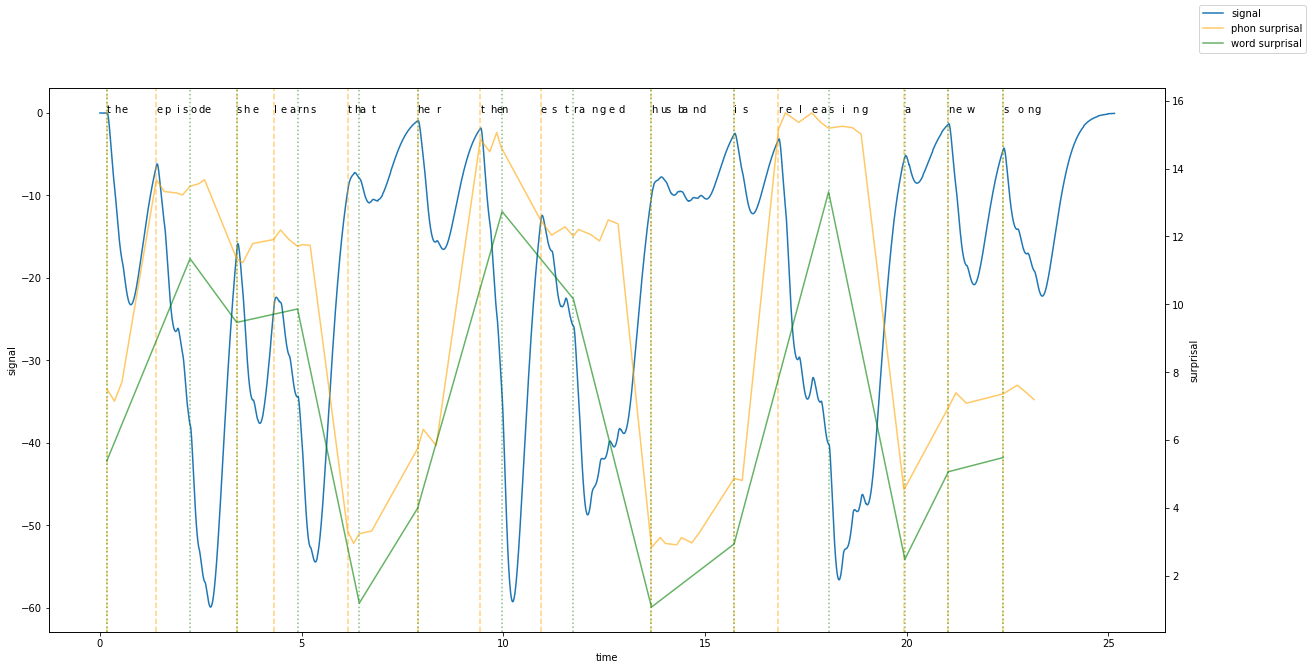

In [102]:
plt.subplots(figsize=(20, 10))
ax = sns.lineplot(data=y, x="time", y="signal")
twinx = ax.twinx()
sns.lineplot(data=X_phon, x="time", y="surprisal", color="orange", alpha=0.6, ax=twinx)
sns.lineplot(data=X_word, x="time", y="surprisal", color="green", alpha=0.6, ax=twinx)
ax.figure.legend(["signal", "phon surprisal", "word surprisal"])

word_onsets = X_phon.groupby("token_idx").apply(lambda xs: xs.iloc[0]).time
for _, phon in X_phon.iterrows():
    ax.annotate(phon.phoneme, xy=(phon.time, 0.1))
for onset in word_onsets:
    ax.axvline(onset, linestyle="--", color="orange", alpha=0.5)
for recognition_onset in X_word.time:
    ax.axvline(recognition_onset, linestyle=":", color="green", alpha=0.5)